<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi Edgar! 👋 Thanks for your detailed and well-structured notebook. You put a lot of effort into exploring different models, and it’s great to see a variety of approaches in action. Here’s my feedback for you:

---

**🟢 Strengths**
    
- **Solid Workflow:** You followed a **clear and logical workflow**: data exploration, preparation, feature engineering, and model building. ✔️
- **Feature Engineering:** Nice work adding **calendar-based features, lags, and rolling means** — all key for time series forecasting! 💡
- **Model Diversity:** You tried multiple models: RandomForest, AR, MA, ARIMA, and auto_arima. Great exploration and experimentation! 🔍
- **Clear Visuals:** You provided **plots for EDA and decomposition**, which helps interpret trends, seasonality, and residuals effectively.
- **Hyperparameter Search:** Your **grid search for Random Forest hyperparameters** is a strong point and shows understanding of model optimization.
- **Final Performance:** Random Forest achieving **RMSE around 16** is an excellent result, well below the 48 threshold. 🚀

---

**🟡 Areas to Improve**
    
- **Conclusion Clarity:** Your conclusion is mostly focused on Random Forest, but it would be helpful to **briefly compare all model performances numerically** to summarize results (e.g., list RMSEs side by side).
- **Feature Function:** Your `make_features` function was nicely built, but it **didn't seem to be used much beyond the Random Forest setup**. For consistency, consider applying similar features across different models too if applicable.

---

**🔴 Critical Issues**
    
Your notebook is **error-free, complete, and fully functional.** You successfully met the main requirement (**RMSE < 48**) and clearly demonstrated a good understanding of time series modeling.

---

Awesome job, Edgar! 🎉 I’m approving your project with no further changes needed. You handled this well, and your use of multiple approaches shows curiosity and technical depth. Keep it up! 🚖✨

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Introduction

**During the course of this project, we will assess or analyze the data provide by the Taxi company.Few models will be select to train data. The RMSE will be use as a metric to predict the amount of taxis orders for the next hours with the purpose of attracting more drivers during peak hours.**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings

In [58]:
warnings.filterwarnings('ignore')

In [59]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [60]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Preparation

In [62]:
data = data.drop_duplicates()

In [63]:
data.duplicated().sum()

0

In [64]:
data.isnull().sum().sum()

0

In [65]:
is_chronological = data.index.is_monotonic
data.sort_index(inplace=True)
display(data.index.is_monotonic)

True

In [66]:
data = data['2018-03-01':'2018-08-31']

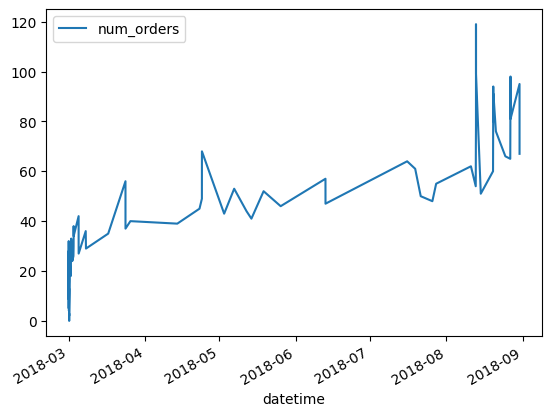

In [67]:
data.plot()
plt.show()

In [68]:
display(data.index.min(), data.index.max())

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-30 18:00:00')

In [69]:
data.describe()

,num_orders
count,81.000000
mean,42.777778
std,28.156260
min,0.000000
25%,20.000000
50%,40.000000
75%,61.000000
max,119.000000


## Analysis

**Here are some keys observations from the plot.**

**Trend:**
**The plot shows seasonal fluctuations with peaks and valleys, suggesting periodic patterns in taxi demand.**
**There is no clear upward or downward trend over the 6-month period—the data appears relatively stable in the long term, with no significant growth or decline.**

**Seasonality:**
**Weekly patterns here could be the repeated spikes and dips likely represent daily or weekly cycles (low/higher demand on weekends or weekdays).**
**Monthly patterns could imply that some months (June–July) may show slightly higher or lower demand, possibly due to holidays, weather, or events.**

**Outliers:**
**A few sharp spikes here, we see values reaching 120 that stand out from the usual range of about 20–80.**

**Missing September Data:**
**The x-axis includes "2018-09," but the plotted data ends in August.This could be a labeling error or truncated data.(?)**
**the display(data.index.min(), data.index.max()) indicate also a Timestamp('2018-03-01 00:00:00') and Timestamp('2018-08-30 18:00:00') missing '2018-08-31'.**



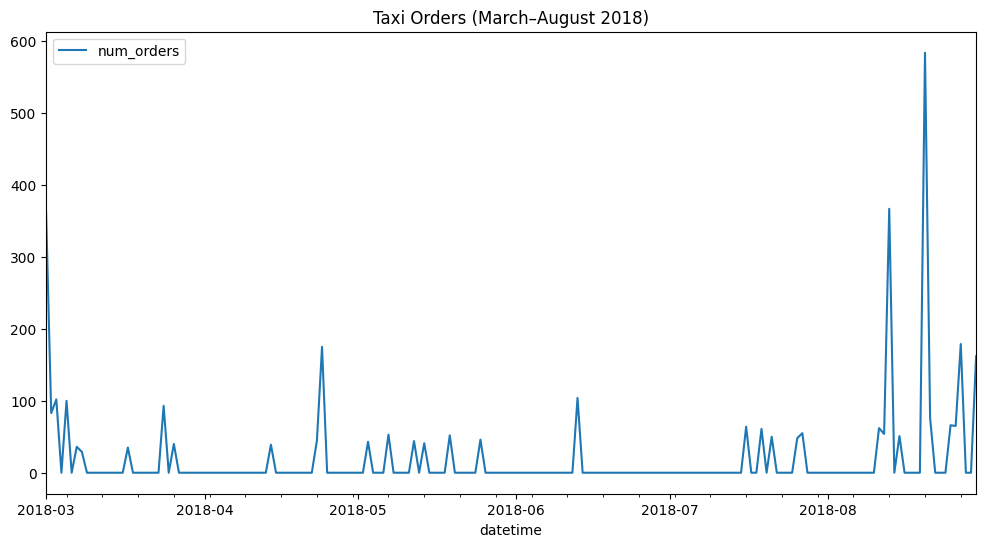

In [70]:
# data resampled daily
daily_resample = data.resample('1D').sum().plot(figsize=(12, 6))

# let set x-axis limits to match data range
daily_resample.set_xlim([data.index.min(), data.index.max()]) 

# let format x-axis to show months
daily_resample.xaxis.set_major_locator(mdates.MonthLocator())
daily_resample.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Taxi Orders (March–August 2018)') 
plt.show()

In [71]:
data = data['2018-03-01':'2018-08-30'].resample('1H').sum()

In [72]:
data['rolling_mean'] = data['num_orders'].rolling(window=10, min_periods=1).mean()

In [73]:
decomposed = seasonal_decompose(data['num_orders'], period=24)

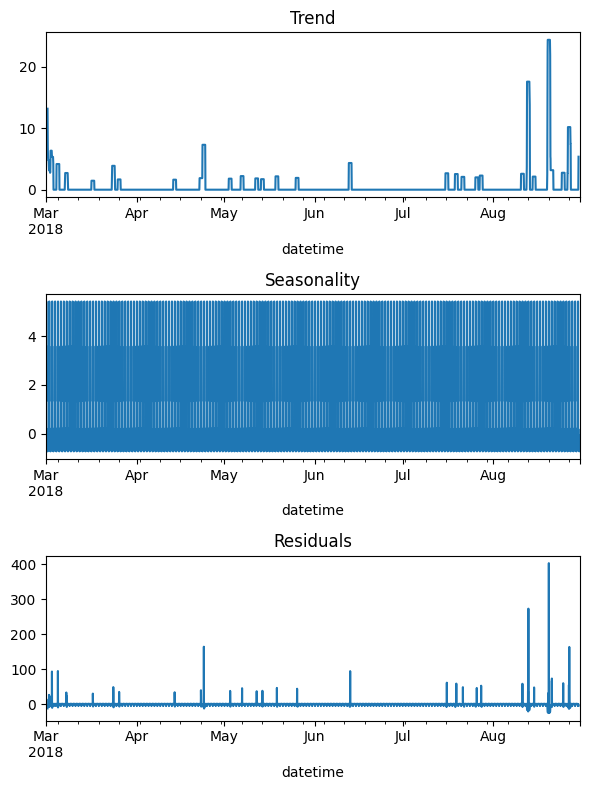

In [74]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())# < write code here >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# < write code here >
plt.title('Residuals')
plt.tight_layout()

In [75]:
data['diff'] = data['num_orders'] - data['num_orders'].shift(1)
data['rolling_mean'] = data['num_orders'].rolling(15).mean()
data['rolling_std'] = data['num_orders'].rolling(15).std()
data.dropna(inplace=True)

In [76]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int)
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
           
    
    data[f'rolling_mean_{rolling_mean_size}'] = (
        data['num_orders'].shift(1).rolling(rolling_mean_size).mean() )
    
# we chose argument values at random
make_features(data, 1, 1)    

## Training / Testing

In [77]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [78]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# MODEL_1 : Random Forest with hyperparameters

In [79]:
best_rmse = float('inf')
best_params = {}

for n_estimators in [50, 100, 200]:
    for max_depth in [5, 10, None]:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=12345)
        model.fit(features_train, target_train)
        pred = model.predict(features_test)
        rmse = mean_squared_error(target_test, pred, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'n_estimators': n_estimators,'max_depth': max_depth,'rmse': rmse }
            

display(f"Best Model -> n_estimators={best_params['n_estimators']}, "
      f"max_depth={best_params['max_depth']}, RMSE={best_params['rmse']:.2f}")

'Best Model -> n_estimators=50, max_depth=5, RMSE=15.83'

# MODEL_2 : AR model

In [80]:
# find optimal number of lags
mod = ar_select_order(endog=train['num_orders'], maxlag=30)
ar_order = mod.ar_lags

# create AR model and fit it using the training set
ar_model = AutoReg(train['num_orders'], lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

# evaluate model using RMSE
ar_rmse_value = mean_squared_error(test['num_orders'], ar_pred, squared=False)
display(ar_rmse_value.round(3))


28.437

# MODEL_3 : Moving Average

In [81]:
# find best MA model order
res = arma_order_select_ic(y=train['num_orders'], max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]# extract MA order from res

# create and fit MA model
ma_model = ARIMA(train['num_orders'], order=(0, 0, ma_order)) # pass order values #for MA
ma_model = ma_model.fit()

# make predictions
start_value = len(train)# calculate starting point for predicitons
end_value = len(train) + len(test) - 1# calculate ending point for #predictions
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

# evaluate model using RMSE
ma_rmse_value = mean_squared_error(test['num_orders'], ma_pred, squared=False)
display(ma_rmse_value.round(3))

28.521

In [82]:
df_stationarityTest = adfuller(train['num_orders'], autolag='AIC')
display("P-value:", df_stationarityTest[1])

'P-value:'

0.0

# MODEL_4 :  Best ARIMA-like mode(Using auto_arima()).

In [ ]:
model = auto_arima(train['num_orders'],
                  stationary=True,  # We know it's stationary
                  seasonal=True,
                  m=12,  # Assuming yearly seasonality
                  trace=True,
                  error_action='ignore',
                  suppress_warnings=True)

Performing stepwise search to minimize aic


In [ ]:
# Get the correct number of steps to forecast
n_forecast_steps = len(test)
# Make predictions (ensure this matches test set length)
predictions = model.predict(n_periods=n_forecast_steps)
# Create a new column initialized with NaN
data['predicted_num_orders'] = np.nan

# Rename the original column
data.rename(columns={'num_orders': 'actual_num_orders'}, inplace=True)
test.rename(columns={'num_orders': 'actual_num_orders'}, inplace=True)
# Fill predictions only in the test period indices
data.loc[test.index, 'predicted_num_orders'] = predictions.values  # Fixed typo in column name
# Evaluate the model predictions
auto_arima_rmse_value = mean_squared_error(test['actual_num_orders'], predictions, squared=False)
print(f"Test RMSE: {auto_arima_rmse_value:.2f}")
# Plot the results with proper formatting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['actual_num_orders'], label='Actual', color='blue')
plt.plot(data.index, data['predicted_num_orders'], label='Predicted', color='orange', linestyle='--')
plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Train/Test Split')
plt.title('Actual vs Predicted Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

model.summary()

# Conclusion

**From all the model train above we see that Random Forest moedel have the lowest RMSE at just under 16.From the Best ARIMA-like mode(Using auto_arima()) the data pattern hows strong weekly seasonality (regular peaks/valleys),possible slight upward trend over the 6-month period and the variance appears relatively stable (no extreme volatility).We can also point that the predictions (orange dashed line) generally follow the actual pattern and captures the seasonal peaks reasonably well.**

# Review checklist

- [x ]  Jupyter Notebook is open
- [x ]  The code is error-free
- [x ]  The cells with the code have been arranged in order of execution
- [x ]  The data has been downloaded and prepared
- [x ]  The data has been analyzed
- [x ]  The model has been trained and hyperparameters have been selected
- [x ]  The models have been evaluated. Conclusion has been provided
- [x ] *RMSE* for the test set is not more than 48